In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

np.random.seed(42)

X, y = make_blobs(
    n_samples=2000,
    centers=5,
    n_features=6,
    cluster_std=3.0,
    random_state=42
)

num_classes = 5
y_onehot = np.eye(num_classes)[y]

print("Input feature shape:", X.shape)
print("One-hot label shape:", y_onehot.shape)

Input feature shape: (2000, 6)
One-hot label shape: (2000, 5)


In [2]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_onehot,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (1500, 6) (1500, 5)
Test set shape: (500, 6) (500, 5)


In [3]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    z_stable = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_stable)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy(y_true, y_pred):
    eps = 1e-9
    return -np.mean(np.sum(y_true * np.log(y_pred + eps), axis=1))

In [4]:
class NeuralNetwork:
    def __init__(self, input_dim, hidden_dims=(32, 16, 8), output_dim=5, lr=0.005):
        self.lr = lr

        h1, h2, h3 = hidden_dims

        self.W1 = np.random.randn(input_dim, h1) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros((1, h1))

        self.W2 = np.random.randn(h1, h2) * np.sqrt(2.0 / h1)
        self.b2 = np.zeros((1, h2))

        self.W3 = np.random.randn(h2, h3) * np.sqrt(2.0 / h2)
        self.b3 = np.zeros((1, h3))

        self.W4 = np.random.randn(h3, output_dim) * np.sqrt(2.0 / h3)
        self.b4 = np.zeros((1, output_dim))

    def forward(self, X):

        self.z1 = X @ self.W1 + self.b1
        self.a1 = relu(self.z1)

        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = relu(self.z2)

        self.z3 = self.a2 @ self.W3 + self.b3
        self.a3 = relu(self.z3)

        self.z4 = self.a3 @ self.W4 + self.b4
        self.a4 = softmax(self.z4)

        return self.a4

    def backward(self, X, y_true):

        m = X.shape[0]

        dZ4 = self.a4 - y_true
        dW4 = (self.a3.T @ dZ4) / m
        db4 = np.sum(dZ4, axis=0, keepdims=True) / m

        dA3 = dZ4 @ self.W4.T
        dZ3 = dA3 * relu_derivative(self.z3)
        dW3 = (self.a2.T @ dZ3) / m
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m

        dA2 = dZ3 @ self.W3.T
        dZ2 = dA2 * relu_derivative(self.z2)
        dW2 = (self.a1.T @ dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * relu_derivative(self.z1)
        dW1 = (X.T @ dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4

        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3

        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def train(self, X, y_true, epochs=300, print_every=50):
        losses = []
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = cross_entropy(y_true, y_pred)
            losses.append(loss)

            self.backward(X, y_true)

            if epoch % print_every == 0:
                print(f"Epoch {epoch} / {epochs} - Loss: {loss:.4f}")

        return losses

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1), probs


In [5]:
input_dim = X_train.shape[1]

model = NeuralNetwork(
    input_dim=input_dim,
    hidden_dims=(32, 16, 8),
    output_dim=num_classes,
    lr=0.005
)

epochs = 300
losses = model.train(X_train, y_train, epochs=epochs, print_every=50)


Epoch 0 / 300 - Loss: 8.0508
Epoch 50 / 300 - Loss: 0.3936
Epoch 100 / 300 - Loss: 0.2274
Epoch 150 / 300 - Loss: 0.1711
Epoch 200 / 300 - Loss: 0.1441
Epoch 250 / 300 - Loss: 0.1280


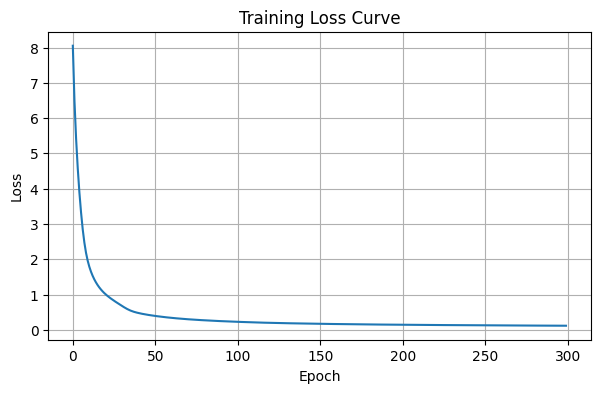

In [6]:

plt.figure(figsize=(7, 4))
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [7]:
y_pred_labels, y_test_probs = model.predict(X_test)
y_true_labels = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9798    0.9700    0.9749       100
           1     0.9899    0.9800    0.9849       100
           2     0.9333    0.9800    0.9561       100
           3     0.9307    0.9400    0.9353       100
           4     0.9896    0.9500    0.9694       100

    accuracy                         0.9640       500
   macro avg     0.9647    0.9640    0.9641       500
weighted avg     0.9647    0.9640    0.9641       500



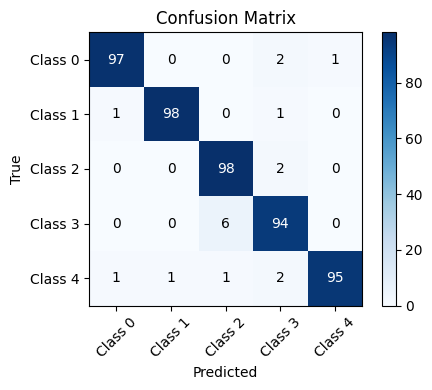

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true_labels, y_pred_labels)
num_classes = cm.shape[0]

plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [f"Class {i}" for i in range(num_classes)], rotation=45)
plt.yticks(tick_marks, [f"Class {i}" for i in range(num_classes)])

plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.tight_layout()
plt.show()


In [9]:
print("Model configuration:")
print("Input features:", input_dim)
print("Hidden layers: 32 -> 16 -> 8")
print("Output classes:", num_classes)
print("Learning rate:", model.lr)
print("Epochs trained:", epochs)

Model configuration:
Input features: 6
Hidden layers: 32 -> 16 -> 8
Output classes: 5
Learning rate: 0.005
Epochs trained: 300
